In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
repickle=False

# Check if pickle exists, and don't re-create it if it does
picklename1 = 'pickles/'+year+'_muonkin.pkl'
if not os.path.isfile(picklename1):
    repickle=True
picklename2 = 'pickles/'+year+'_mujetkin.pkl'
if not os.path.isfile(picklename2):
    repickle=True

In [5]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vbf-muon/outfiles/'+year+'_'+str(n)+'.coffea'
        #filename = '../vbf-muon/outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}

    muonkin = outsum['muonkin']
    mujetkin = outsum['mujetkin']
    
    muonkin.scale(scale_lumi, 'dataset')
    mujetkin.scale(scale_lumi, 'dataset')

    muonkin = muonkin.group('dataset', hist.Cat('process', 'Process'), pmap)
    mujetkin = mujetkin.group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename1, 'wb')
    pickle.dump(muonkin, outfile, protocol=-1)
    outfile.close()
    
    outfile = open(picklename2, 'wb')
    pickle.dump(mujetkin, outfile, protocol=-1)
    outfile.close()

In [6]:
cutflow = pickle.load(open('pickles/'+str(year)+'_cutflow.pkl','rb'))
cutflow = cutflow.sum('genflavor').integrate('region','muoncontrol')

In [7]:
cutflow.integrate('process','muondata').values()

{(): array([2.9164308e+07, 1.6151331e+07, 5.8711900e+05, 5.8711900e+05,
        1.9092900e+05, 5.2448000e+04, 4.8654000e+04, 7.7040000e+03,
        4.0390000e+03, 3.3900000e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00])}

In [8]:
cutflow.integrate('process','ttbar').values()

{(): array([9.28402879e+05, 9.28402879e+05, 3.00075848e+05, 3.00075848e+05,
        1.02232393e+05, 4.89804311e+04, 3.69600939e+04, 4.80770731e+03,
        2.74022822e+03, 2.87640608e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00])}

In [9]:
df1 = pd.DataFrame([])

df1['QCD'] = cutflow.values()[('QCD',)]
df1['Wjets'] = cutflow.values()[('Wjets',)]
df1['Zjets'] = cutflow.values()[('Zjets',)]
df1['VV'] = cutflow.values()[('VV',)]
df1['ttbar'] = cutflow.values()[('ttbar',)]
df1['singlet'] = cutflow.values()[('singlet',)]
df1['data'] = cutflow.values()[('muondata',)]

df1 = df1[1:10].astype('int')
df1.index = ['Jet kinematics','Jet ID','Jet $N_2^\text{DDT}$','b-tag','No e/tau','One muon','Dphi(muon,AK8)','AK4jets','DeepDoubleB']
df1.to_latex(buf=year+'/cutflow-muoncr.tex')

In [10]:
deta_cut = 0
mjj_cut = 0

In [11]:
templates = pickle.load(open('pickles/'+str(year)+'_templates.pkl','rb'))
templates = templates.integrate('systematic','nominal')
muonkin = pickle.load(open('pickles/'+str(year)+'_muonkin.pkl','rb'))
mujetkin = pickle.load(open('pickles/'+str(year)+'_mujetkin.pkl','rb'))

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16b1c47dc0>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16b1c47dc0>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16b1c47dc0>
  warnings.warn(


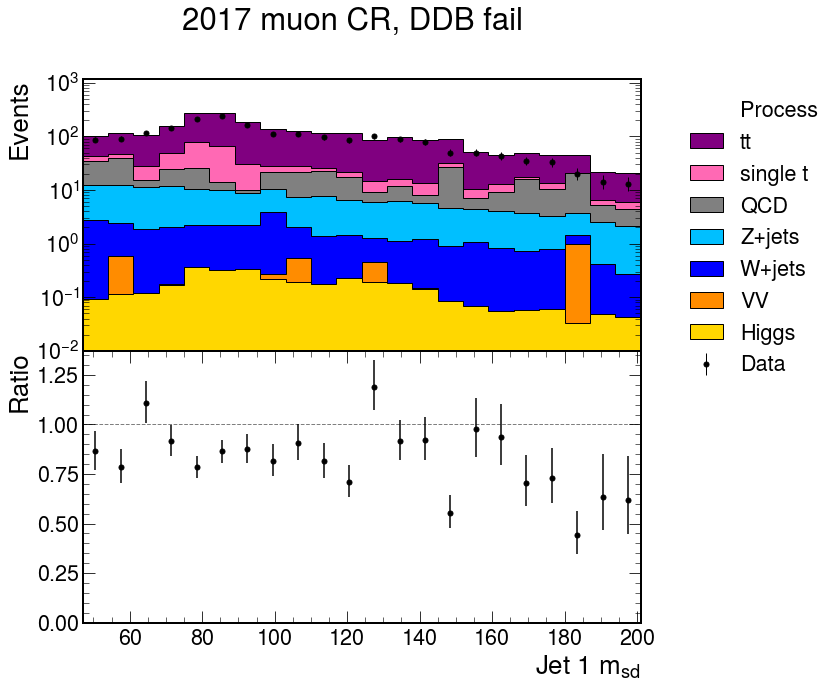

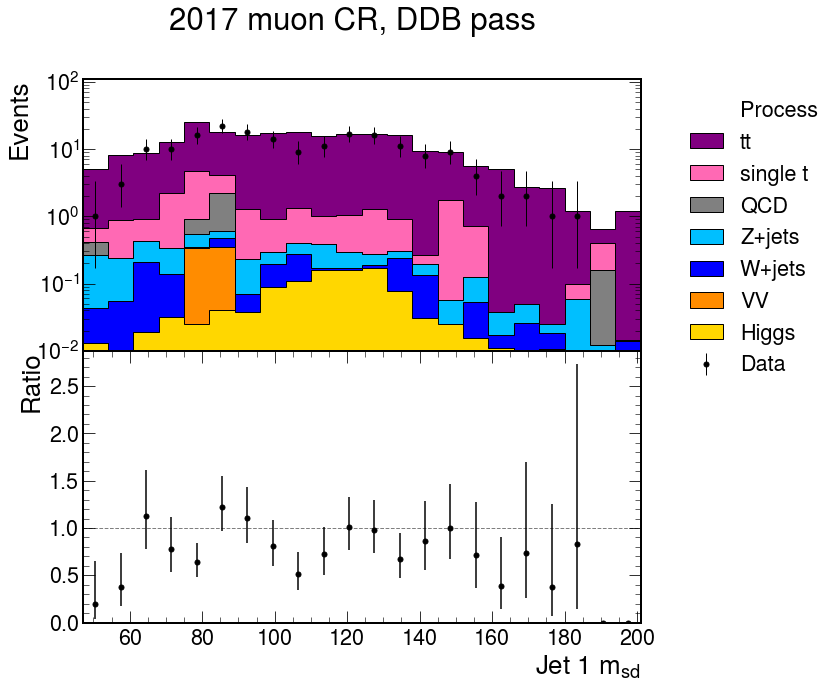

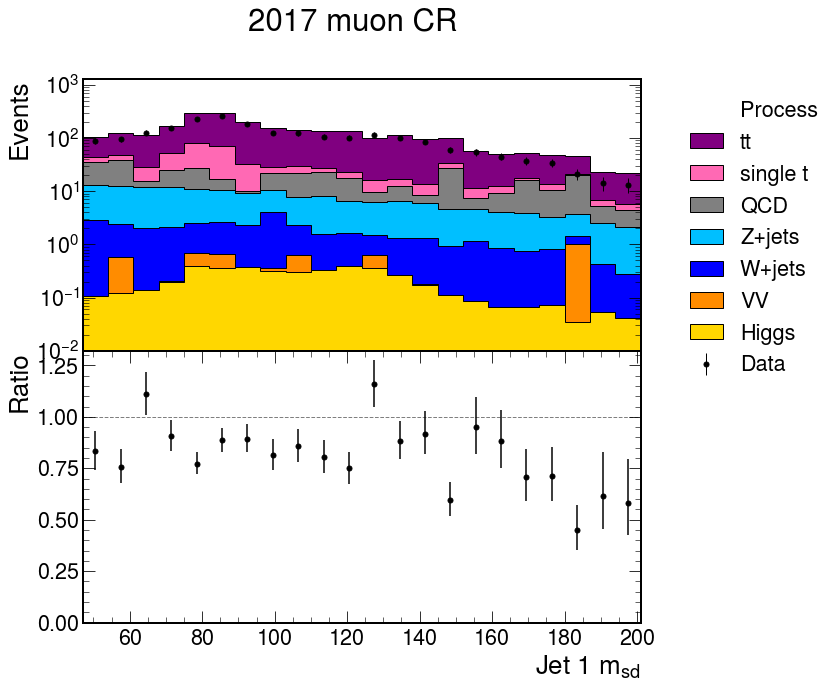

In [12]:
h = templates.integrate('region', 'muoncontrol').sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1_fail',year+" muon CR, DDB fail")
h = templates.integrate('region', 'muoncontrol').sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1_pass',year+" muon CR, DDB pass")
h = templates.integrate('region', 'muoncontrol').sum('ddb1','pt1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16b1c47dc0>
  warnings.warn(


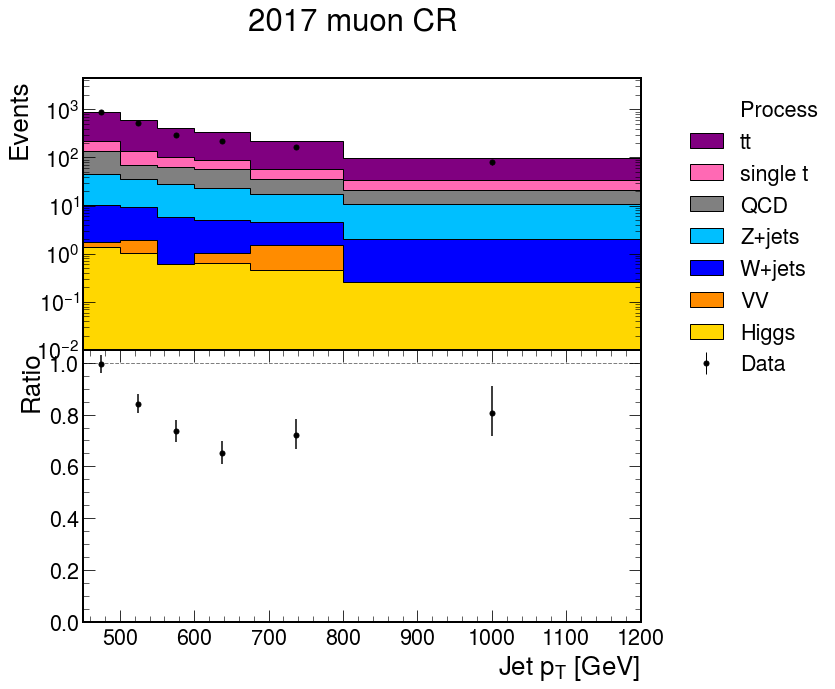

In [13]:
h = templates.integrate('region', 'muoncontrol').sum('ddb1','msd1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_pt1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4670>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw


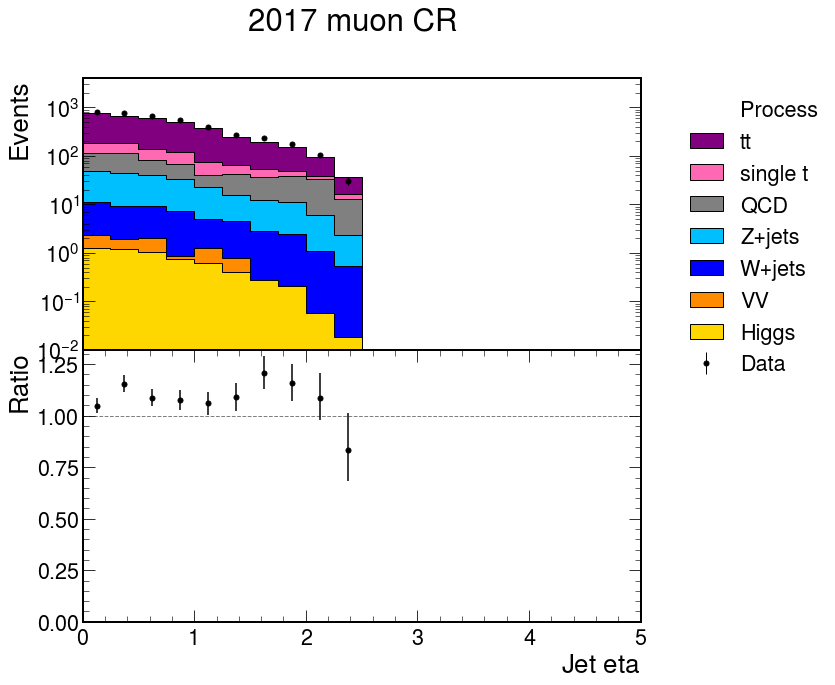

In [14]:
h = mujetkin.integrate('region', 'muoncontrol').sum('ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_eta1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4670>
  warnings.warn(


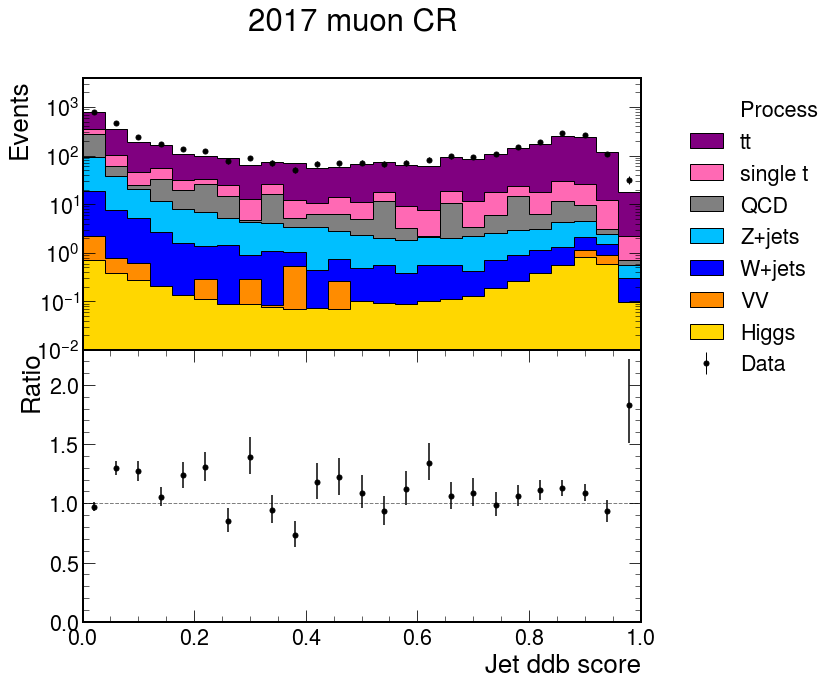

In [15]:
h = mujetkin.integrate('region', 'muoncontrol').sum('eta1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ddb1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4b20>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4b20>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_int

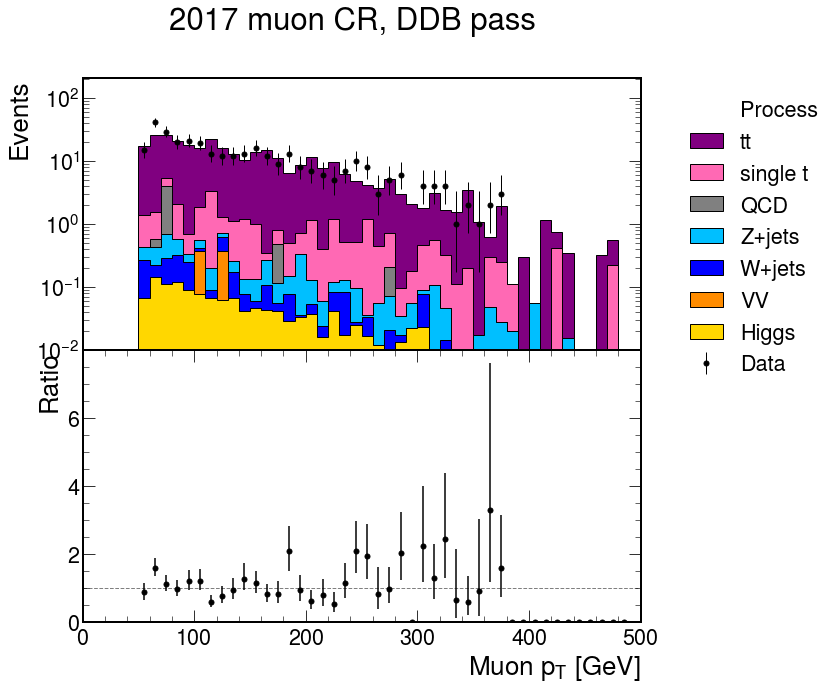

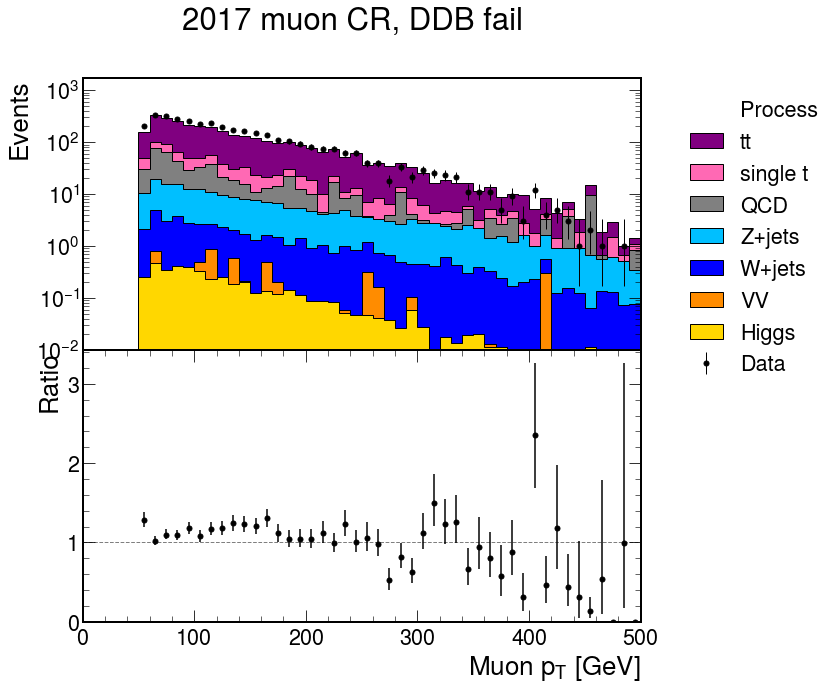

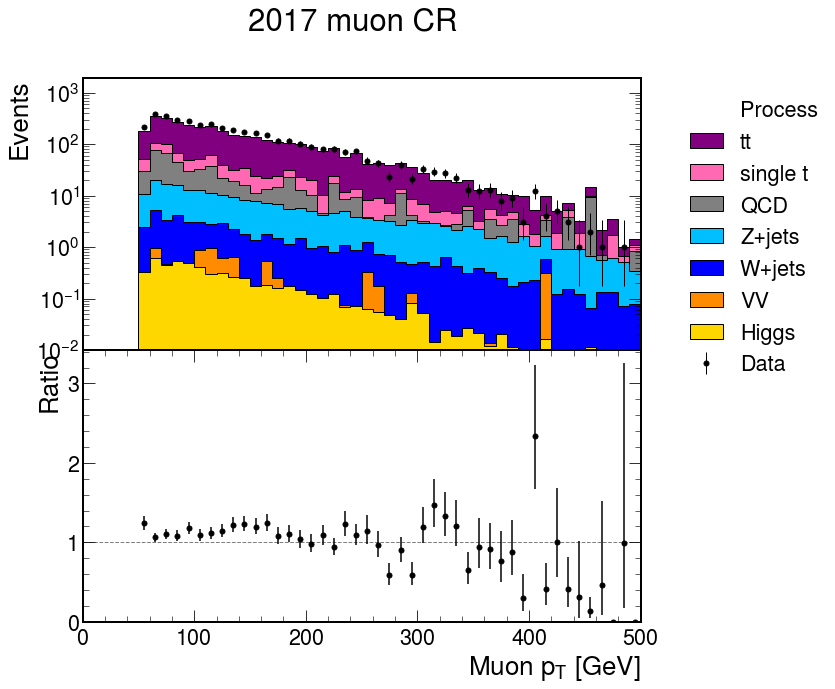

In [16]:
h = muonkin.integrate('region', 'muoncontrol').sum('etamu',).integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4b20>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f16659a4b20>
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_int

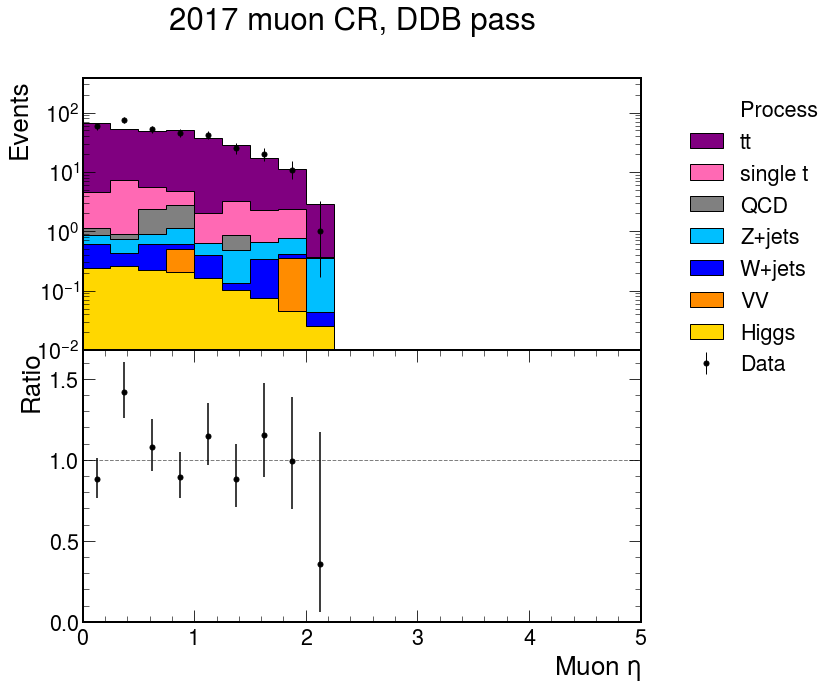

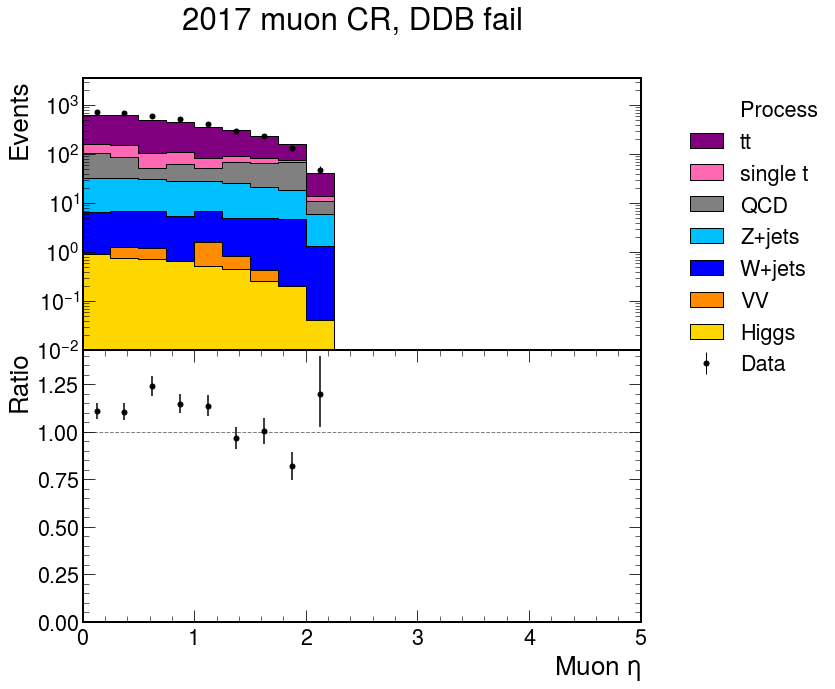

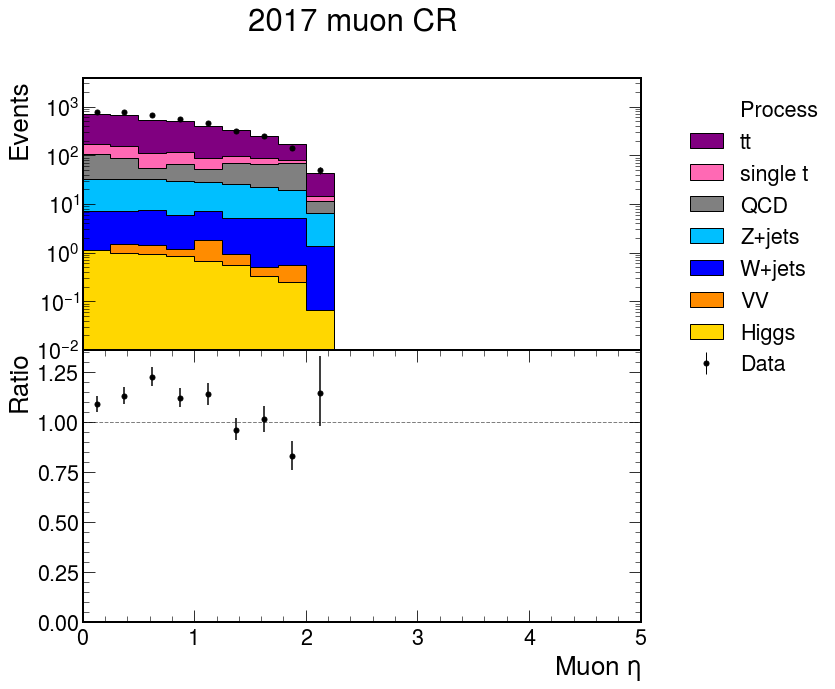

In [17]:
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu',year+" muon CR")

ValueError: plot1d() can only support up to two dimensions (one for axis, one to stack or overlay)

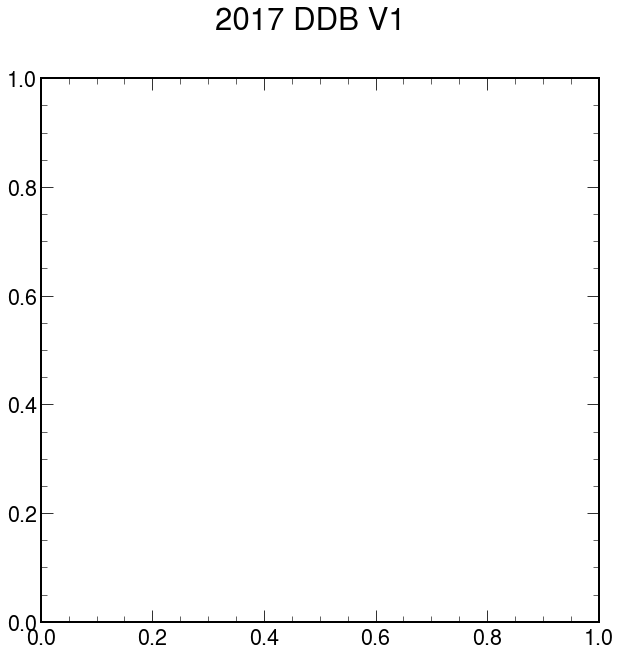

In [18]:
h = mujetkin.integrate('region', 'signal').sum('eta1')
plot_mconly_vbf(h,year+'/SR_ddb1',year+" DDB V1")